<a href="https://colab.research.google.com/github/mahmoudarekat/MetabolicSyndrome/blob/main/MetabolicSyndrome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import Necessary Libraries

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
set_config(transform_output='pandas')
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, \
ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def explore_numeric(df, x, figsize=(6,5) ):
  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}")
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")

####Classification Metrics

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(list(y_true.values), y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



####Evaluate Classification

In [6]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict


###Fetching Data

In [7]:
df=pd.read_csv('/content/drive/MyDrive/Datasets/Metabolic  Syndrome.csv').set_index('seqn')
df

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
seqn,,,,,,,,,,,,,,
62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71901,48,Female,Married,1000.0,Other,NaN,59.7,0,22.11,5.8,152,57,107,No MetSyn
71904,30,Female,Single,2000.0,Asian,NaN,18.0,0,2.90,7.9,91,90,91,No MetSyn
71909,28,Male,Single,800.0,MexAmerican,100.8,29.4,0,2.78,6.2,99,47,84,No MetSyn


###Data Cleaning

In [8]:
df.describe()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
count,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,48.691795,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364
std,17.632852,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477
min,20.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000
25%,34.000000,1600.000000,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000
50%,48.000000,2500.000000,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000
75%,63.000000,6200.000000,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000
max,80.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2401 entries, 62161 to 71915
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2401 non-null   int64  
 1   Sex                2401 non-null   object 
 2   Marital            2193 non-null   object 
 3   Income             2284 non-null   float64
 4   Race               2401 non-null   object 
 5   WaistCirc          2316 non-null   float64
 6   BMI                2375 non-null   float64
 7   Albuminuria        2401 non-null   int64  
 8   UrAlbCr            2401 non-null   float64
 9   UricAcid           2401 non-null   float64
 10  BloodGlucose       2401 non-null   int64  
 11  HDL                2401 non-null   int64  
 12  Triglycerides      2401 non-null   int64  
 13  MetabolicSyndrome  2401 non-null   object 
dtypes: float64(5), int64(5), object(4)
memory usage: 281.4+ KB


In [10]:
df.isna().sum()

Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

In [11]:
df['MetabolicSyndrome'].value_counts()

No MetSyn    1579
MetSyn        822
Name: MetabolicSyndrome, dtype: int64

In [12]:
null_mask = df.isnull().any(axis=1)
null_rows = df[null_mask]
null_rows['MetabolicSyndrome'].value_counts()

No MetSyn    282
MetSyn       110
Name: MetabolicSyndrome, dtype: int64

In [13]:
df=df.dropna()

In [14]:
for i in df:
  print(df[i].value_counts())

80    104
63     48
50     44
60     43
21     42
     ... 
73     18
76     18
77     17
79     15
72     15
Name: Age, Length: 61, dtype: int64
Female    1022
Male       987
Name: Sex, dtype: int64
Married      1098
Single        460
Divorced      219
Widowed       144
Separated      88
Name: Marital, dtype: int64
9000.0    316
2500.0    223
3500.0    204
2000.0    177
1000.0    174
8200.0    171
1600.0    157
6200.0    124
4500.0    118
800.0     109
5400.0     94
300.0      69
1700.0     50
1500.0     23
Name: Income, dtype: int64
White          806
Black          462
Asian          295
MexAmerican    198
Hispanic       198
Other           50
Name: Race, dtype: int64
97.0     19
100.0    16
103.0    12
91.6     11
89.0     11
         ..
142.0     1
129.2     1
132.6     1
125.2     1
69.5      1
Name: WaistCirc, Length: 616, dtype: int64
24.7    21
23.3    20
25.8    18
22.0    18
24.9    18
        ..
19.7     1
68.7     1
44.8     1
51.8     1
45.3     1
Name: BMI, Length: 308, 

In [15]:
df.head()

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
seqn,,,,,,,,,,,,,,
62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
62178,80,Male,Widowed,300.0,White,112.5,28.5,0,9.79,4.8,105,47,100,No MetSyn


In [16]:
y=df['MetabolicSyndrome']
X=df.drop(columns='MetabolicSyndrome')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

####Preprocessing Numeric

In [18]:
num_cols = X_train.select_dtypes("number").drop(columns='Albuminuria').columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(scaler)
num_pipe

Numeric Columns: Index(['Age', 'Income', 'WaistCirc', 'BMI', 'UrAlbCr', 'UricAcid',
       'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')


Pipeline(steps=[('standardscaler', StandardScaler())])

In [19]:
# PREPROCESSING PIPELINE FOR ORDINAL DATA
# Save list of column names
ord_cols = ['Albuminuria']
print("Ordinal Columns:", ord_cols)
# Create imputer for ordinal data
## Making the OrdinalEncoder
# Specifying order of categories for our  Ordinal Qual/Cond Columms
Alb_order = ['0','1','2']
# Making the list of order lists for OrdinalEncoder
ordinal_category_orders = [Alb_order]
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
# Making a final scaler to scale category #'s
scaler_ord = StandardScaler()
## Making an ord_pipe
ord_pipe = make_pipeline(ord_encoder, scaler_ord)
ord_pipe

Ordinal Columns: ['Albuminuria']


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(categories=[['0', '1', '2']])),
                ('standardscaler', StandardScaler())])

In [20]:
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(drop='first',sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline( ohe_encoder)
ohe_pipe

OneHotEncoder Columns: Index(['Sex', 'Marital', 'Race'], dtype='object')


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))])

In [21]:
num_tuple = ('numeric', num_pipe, num_cols)
ord_tuple=('ordinal',ord_pipe,ord_cols)
ohe_tuple=('categorical', ohe_pipe, ohe_cols)

In [22]:
col_transformer = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)

In [23]:
logreg=LogisticRegression(C=10)
scaler=StandardScaler()
logreg_pipe=make_pipeline(col_transformer,logreg)
logreg_pipe.fit(X_train,y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Income', 'WaistCirc', 'BMI', 'UrAlbCr', 'UricAcid',
       'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['0',
                                                                                               '1',
                                                                                               '2']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Albuminuria']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Sex', 'Marital', 'Race'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('logisticregression', LogisticRegression(C=10))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.82      0.74      0.78       531
   No MetSyn       0.87      0.91      0.89       975

    accuracy                           0.85      1506
   macro avg       0.84      0.82      0.83      1506
weighted avg       0.85      0.85      0.85      1506



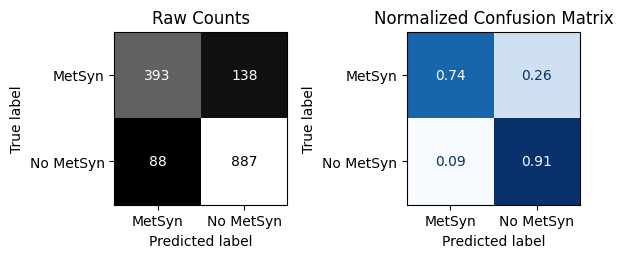


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.74      0.72      0.73       181
   No MetSyn       0.84      0.86      0.85       322

    accuracy                           0.81       503
   macro avg       0.79      0.79      0.79       503
weighted avg       0.81      0.81      0.81       503



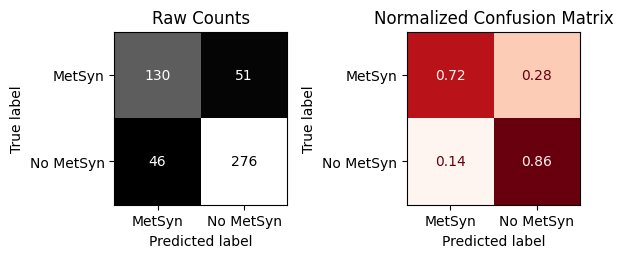

In [24]:
evaluate_classification(logreg_pipe, X_train, y_train, X_test, y_test)


In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42)
X_train.head()


,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
seqn,,,,,,,,,,,,,
69994,21,Female,Single,6200.0,Other,64.2,18.2,0,26.45,3.6,94,61,71
68237,63,Male,Married,4500.0,White,102.5,29.6,0,3.33,6.7,101,46,80
65335,55,Male,Married,5400.0,Asian,107.0,29.3,0,6.24,7.1,98,46,65
70489,40,Male,Married,3500.0,Hispanic,105.8,30.3,0,3.24,5.5,103,55,75
66851,46,Female,Widowed,9000.0,White,107.2,28.7,0,7.09,5.3,103,64,80


###Clustering

In [33]:
X_trans=col_transformer.transform(X)


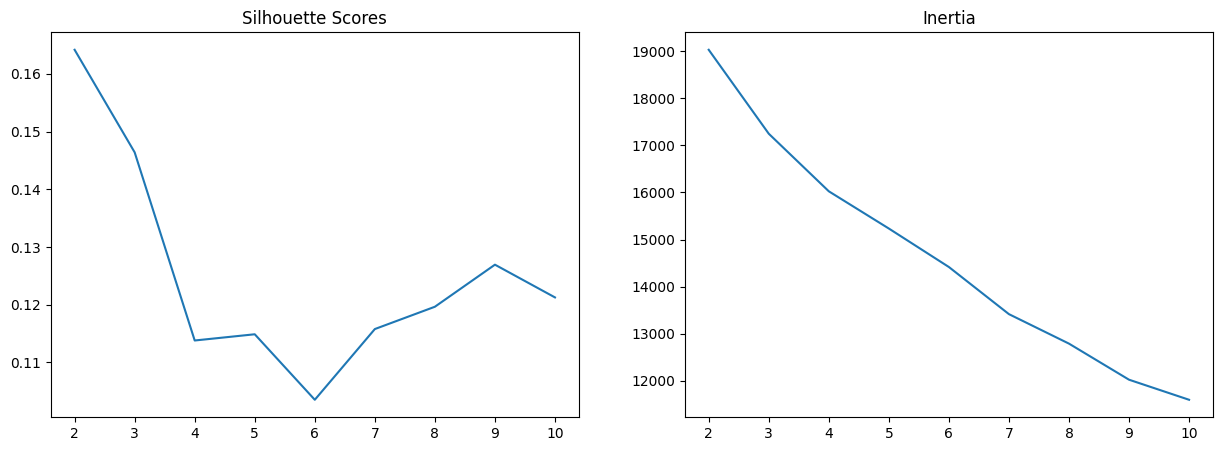

In [34]:
# Iterate over a range of k clusters to find the optimal number of clusters
ks = range(2,11)
sils = []
inertias = []
for k in ks:
  kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state=42)
  kmeans.fit(X_trans)
  sils.append(silhouette_score(X_trans, kmeans.labels_))
  inertias.append(kmeans.inertia_)
#plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(ks, sils)
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias)
axes[1].set_title('Inertia')
axes[1].set_xticks(ks);

In [36]:
# Refit KMeans with 2 clusters
kmeans = KMeans(n_clusters=2, n_init= 'auto', random_state=42)
kmeans.fit(X_trans)
# Add the clusters as a column in the dataframe
df['cluster'] = kmeans.labels_
df.head()

<ipython-input-36-08dab6a8d9f4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.labels_


,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome,cluster
seqn,,,,,,,,,,,,,,,
62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn,1
62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn,1
62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn,1
62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn,0
62178,80,Male,Widowed,300.0,White,112.5,28.5,0,9.79,4.8,105,47,100,No MetSyn,0


In [38]:
# Group the dataframe by cluster and aggregate by mean values
# Add as_index=False so that the clusters are a column, not the index
cluster_groups = df.groupby('cluster', as_index=False).mean()
cluster_groups

<ipython-input-38-5eb2330caace>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_groups = df.groupby('cluster', as_index=False).mean()


,cluster,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
0,0,54.759364,3677.979569,111.299886,33.369807,0.256527,76.865607,6.249830,121.583428,45.611805,167.064699
1,1,44.971631,4513.652482,88.545922,25.112411,0.062057,15.220239,4.899202,97.406028,59.751773,95.517730


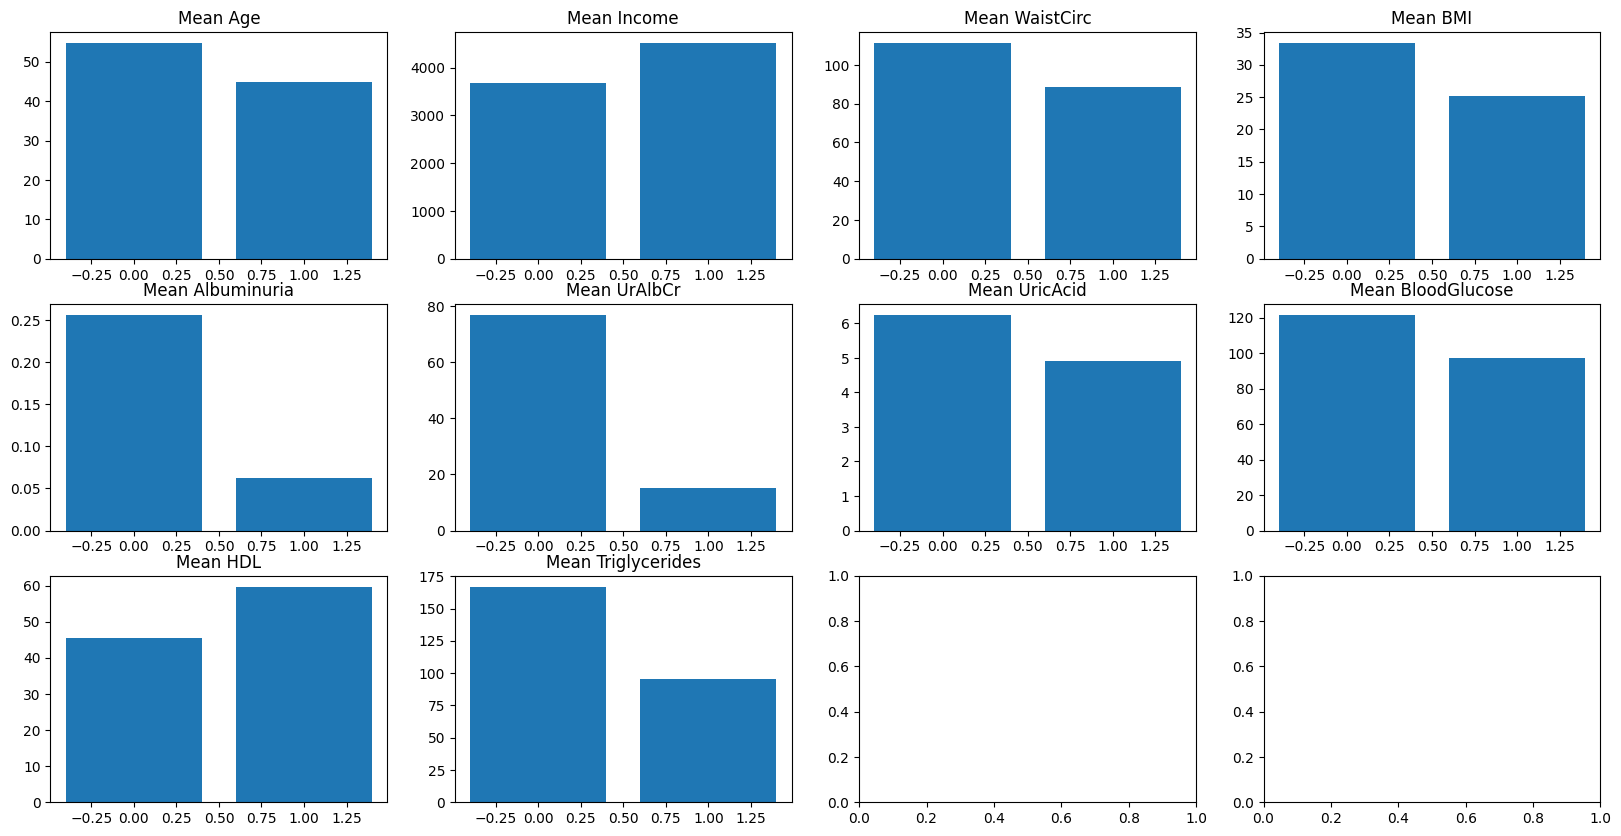

In [39]:
# Visualize means
fig, axes = plt.subplots(3,4, figsize = (20, 10))
# fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')